In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import make_scorer, jaccard_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, plot_confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.manifold import TSNE
from sklearn import preprocessing
#import ternary
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import LinearSegmentedColormap
#from geopandas import GeoDataFrame
#from shapely.geometry import Point
#sns.set()
#sns.set()

In [14]:
def flatten(container):
    "Flattens lists"
    for i in container:
        if isinstance(i, (list, tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

def feature_list(no_of_neighbors):
    """
    Creates a list of features given number of adjacent wells
    param no_of_neighbors: number of adjacent wells used in feature engineering
    """
    print("Getting the features")
    initial = ["thickness", "thickness natural log", "thickness power"]
    features = []
    for item in initial:
        features.append(item)
        for i in range(1, no_of_neighbors + 1):
            features.append(item + " neighbor " + str(i))
    features.append(["x location", "y location", "le_class"])
    return list(flatten(features))

def data_normalization(dataframe):
    """
    Normalizes the generated stratigraphic data
    param dataframe: a pandas dataframe of thicknesses that has been through feature engineering
    param location: a pandas dataframe with locations 
    """
    print("normalizing")
    normalized_df = (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min()).replace(0, 0.00001)
    return normalized_df
    

def adjacent_wells(dataframe, no_of_neighbors):
    """
    Calculates the adjacent wells and builds the initial dataframe
    param dataframe: dataframe output from the missing function
    param no_of_neighbors: number of adjacent wells used in feature engineering
    """
    hood = squareform(pdist(dataframe.iloc[:, -2:]))
    neighbors = []
    for i in enumerate(hood.argsort()[0:, 1 : no_of_neighbors + 1]):
        selected = (
            dataframe.iloc[hood.argsort()[i[0], 1 : no_of_neighbors + 1], 0:-2]
            .stack()
            .to_frame()
            .T
        )
        selected.columns = selected.columns.droplevel()
        neighbors.append(selected)
    frame = pd.concat(neighbors, sort=False)
    frame.index = range(len(frame))
    neighborhood = pd.concat([dataframe.iloc[:, :-2], frame], axis=1)
    return neighborhood
    
def depth_to_thickness(neighborhood, dataframe):
    """
    Converts the depth dataframe from the adjacent wells function to thicknesses
    param neighborhood: dataframe output from `adjacent_wells`
    param dataframe: dataframe output from function `missing`
    """
    locations = pd.DataFrame()
    df = pd.DataFrame()
    thicknesses = neighborhood.diff(axis=1)*-1
    thicknesses[thicknesses < 0] = 0
    thicknesses.drop(columns=dataframe.columns[0], inplace=True)
    thicknesses[thicknesses < 0] = 0
    thicknesses[thicknesses > 3000] = 0
    locations = pd.concat((locations, dataframe.iloc[:, -2:]))
    df = pd.concat((df, thicknesses))
    return df, locations
  


def build_feature_engineered_dataset(thickness_df, locations_df):
    """
    Takes the generated thickness dataset and runs feature engineering
    param thickness_df: the generated thickness dataset
    param locations_df: the generated locations dataset    
    """
    log_transform = FunctionTransformer(np.log, validate=False)
    power_transform = FunctionTransformer(lambda x: x ** 10, validate=False)
    
    logged = pd.DataFrame(log_transform.transform(thickness_df))
    powered = pd.DataFrame(power_transform.transform(thickness_df)) 
    feature_dataset = (
        pd.concat([thickness_df, logged, powered, locations_df], axis=1)
        .dropna()
        .replace(-np.inf, 0)
    )
    return feature_dataset
  

In [15]:
TRUNCATION_COLOR = "#ffffbf"
ONLAP_COLOR = "#2c7bb6"
HORIZ_COLOR = "#d7191c"
 
truncCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", TRUNCATION_COLOR])
onlapCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", ONLAP_COLOR])
horizCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", HORIZ_COLOR])

In [16]:
TRAINING_DATA = pd.read_csv(r'399neighbors.csv', index_col=[0])
le = preprocessing.LabelEncoder()
le_class = le.fit_transform(TRAINING_DATA['class'])
TRAINING_DATA.loc[:,'le_class'] =  le_class
TRAINING_DATA.drop('class', inplace=True, axis=1)

In [98]:
# Dataset at https://osf.io/a6cwh/
TOPS_API = pd.read_csv(
    r"subsurface_data.csv"
).fillna(
    0
)  
ITERABLE = ["Kfh", "Kl", "Tfu"]
TOPCOMBOS = list(zip(ITERABLE, ITERABLE[1:]))

In [213]:
ACCURACY_MEASURED = []  # for the cross-validation accuracy
VICINITY = []  # the number of adjacent wells
UNCERTAINTY = [] # value of 2 is lowest, value of ~1 is random
TIME = []
FULL_ACTIVE_UNC = []
grid_params = {
    'bootstrap': [True, False],
    'max_depth': [1, 10, 100],
    'min_samples_leaf': [10, 100, 1000],
    'min_samples_split': [10, 100, 1000],
    'n_estimators': [10, 100, 1000],
    'criterion': ['gini', 'entropy']
}
VICINITY_TO_CHECK = [
    #0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
    25, 50, 75, 100, 150, 200, 250, 300, 350, 399
]
scoring = make_scorer(jaccard_score, average='weighted')

In [ ]:
for i in VICINITY_TO_CHECK:
    print(f'{i} number of wells in vicinity')
    wells_in_vicinity = i
    flat_features = feature_list(wells_in_vicinity)
    subset = TRAINING_DATA[flat_features]
    X_train, X_test, y_train, y_test = train_test_split(
        subset.drop("le_class", axis=1), subset["le_class"], test_size=0.2, 
        random_state=86,
    )
    gs = GridSearchCV(RandomForestClassifier(), grid_params, verbose=0.2, 
                      cv=5, n_jobs=7,scoring=scoring)
    gs_results = gs.fit(X_train, y_train)
    rtclf = RandomForestClassifier(**gs.best_params_)
    rtclf.fit(X_train, y_train)
    score = jaccard_score(y_test, rtclf.predict(X_test), average='weighted')
    preds = rtclf.predict_proba(X_test)
    dists = []
    for k in enumerate(preds):
        dists.append(sorted(k[1])[-1]-sorted(k[1])[-2])
    UNCERTAINTY.append(np.mean(dists))
    ACCURACY_MEASURED.append(score)
    VICINITY.append(wells_in_vicinity)
    TIME.append(gs.refit_time_)
    ACTIVE_UNC = []
    RESULTS = []
    NORM_ALL = []
    PROBS_ALL = []
    FULL_PROBS = []
    # now for active learning
    for j in enumerate(TOPCOMBOS):
        print(TOPCOMBOS[j[0]])
        fmtops = list(TOPCOMBOS[j[0]])
        fmtops.extend(["x", "y"])
        tops = TOPS_API[fmtops]
        hoods = adjacent_wells(tops, wells_in_vicinity)
        thicknesses, locations = depth_to_thickness(hoods, tops)
        ft_eng = build_feature_engineered_dataset(thicknesses, locations)
        normalized = data_normalization(ft_eng)
        normalized.columns = flat_features[:-1]
        
        well_prob = rtclf.predict_proba(normalized.sample(frac=0.05,random_state=i*2).values)
        FULL_PROBS.append(well_prob)
        probs = []
        for l in range(len(well_prob)):
            probs.append(well_prob[l].max())
        dists = []
        for m in enumerate(well_prob):
            dists.append(sorted(m[1])[-1]-sorted(m[1])[-2])
        ACTIVE_UNC.append(np.mean(dists))
        PROBS_ALL.append(probs)
        NORM_ALL.append(normalized)
    FULL_ACTIVE_UNC.append(ACTIVE_UNC)


25 number of wells in vicinity
Getting the features
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  45 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 220 tasks      | elapsed: 11.4min
[Parallel(n_jobs=7)]: Done 511 tasks      | elapsed: 30.2min
[Parallel(n_jobs=7)]: Done 920 tasks      | elapsed: 83.1min
[Parallel(n_jobs=7)]: Done 1444 tasks      | elapsed: 158.7min
[Parallel(n_jobs=7)]: Done 1620 out of 1620 | elapsed: 211.5min finished


('Kfh', 'Kl')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
('Kl', 'Tfu')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
50 number of wells in vicinity
Getting the features
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 220 tasks      | elapsed: 15.8min
[Parallel(n_jobs=7)]: Done 511 tasks      | elapsed: 42.8min
[Parallel(n_jobs=7)]: Done 920 tasks      | elapsed: 121.1min
[Parallel(n_jobs=7)]: Done 1444 tasks      | elapsed: 231.8min
[Parallel(n_jobs=7)]: Done 1620 out of 1620 | elapsed: 310.8min finished


('Kfh', 'Kl')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
('Kl', 'Tfu')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
75 number of wells in vicinity
Getting the features
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 220 tasks      | elapsed: 19.0min
[Parallel(n_jobs=7)]: Done 511 tasks      | elapsed: 52.4min
[Parallel(n_jobs=7)]: Done 920 tasks      | elapsed: 148.9min
[Parallel(n_jobs=7)]: Done 1444 tasks      | elapsed: 285.8min
[Parallel(n_jobs=7)]: Done 1620 out of 1620 | elapsed: 385.3min finished


('Kfh', 'Kl')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
('Kl', 'Tfu')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
100 number of wells in vicinity
Getting the features
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 220 tasks      | elapsed: 21.5min
[Parallel(n_jobs=7)]: Done 511 tasks      | elapsed: 59.2min
[Parallel(n_jobs=7)]: Done 920 tasks      | elapsed: 168.0min
[Parallel(n_jobs=7)]: Done 1444 tasks      | elapsed: 321.4min
[Parallel(n_jobs=7)]: Done 1620 out of 1620 | elapsed: 433.5min finished


('Kfh', 'Kl')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
('Kl', 'Tfu')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
150 number of wells in vicinity
Getting the features
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  45 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 220 tasks      | elapsed: 26.1min
[Parallel(n_jobs=7)]: Done 511 tasks      | elapsed: 71.1min
[Parallel(n_jobs=7)]: Done 920 tasks      | elapsed: 202.0min
[Parallel(n_jobs=7)]: Done 1444 tasks      | elapsed: 388.7min
[Parallel(n_jobs=7)]: Done 1620 out of 1620 | elapsed: 526.2min finished


('Kfh', 'Kl')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
('Kl', 'Tfu')


/home/thedude/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
200 number of wells in vicinity
Getting the features
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 220 tasks      | elapsed: 29.0min
[Parallel(n_jobs=7)]: Done 511 tasks      | elapsed: 79.1min
[Parallel(n_jobs=7)]: Done 920 tasks      | elapsed: 223.5min


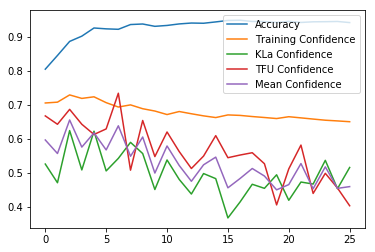

In [206]:
plt.plot(VICINITY, ACCURACY_MEASURED, label='Accuracy')
plt.plot(VICINITY, UNCERTAINTY, label='Training Confidence' )
plt.plot(VICINITY,np.array(FULL_ACTIVE_UNC)[:,0], label='KLa Confidence' )
plt.plot(VICINITY, np.array(FULL_ACTIVE_UNC)[:,1], label='TFU Confidence' )
plt.plot(VICINITY, np.mean(FULL_ACTIVE_UNC, axis=1), label='Mean Confidence')
plt.legend()

In [209]:
# zero to 25 wells in vicinity accuracy
zero_to_tf_acc = [0.8044564654145497,
 0.8446204636908732,
 0.8858748000641838,
 0.9013172995871331,
 0.9252605947855298,
 0.9227407973553855,
 0.9214134192196591,
 0.9353630148424044,
 0.9369724254518846,
 0.9301278432889878,
 0.932708649760228,
 0.9371889033690519,
 0.9397759940130866,
 0.939147673602454,
 0.9430829010645561,
 0.9473344496524662,
 0.9479799367295766,
 0.944373478215261,
 0.9440714274371722,
 0.9414353995947474,
 0.9447432060041452,
 0.9415114741457378,
 0.9434041271000553,
 0.9437344744623425,
 0.9443841956902258,
 0.9411356350110636]
# zero to 25 wells in vicinity certainty on training data
zero_to_tf_tr_cer = [0.7052792205356949,
 0.7076948182288822,
 0.7289418025057284,
 0.7186863705072882,
 0.7233797055301987,
 0.7062390455747898,
 0.6933931308374747,
 0.6997015718215593,
 0.6884355028572393,
 0.681654655736853,
 0.6713507516944909,
 0.6802337230970278,
 0.6736493004151825,
 0.6674828043120707,
 0.6625155716654667,
 0.6702435456921081,
 0.6688447039311686,
 0.665505918504963,
 0.6626626291572012,
 0.6596240253616265,
 0.6649871803289962,
 0.6615760787817095,
 0.658088083640591,
 0.6547246539453763,
 0.6526533140764124,
 0.6503294208385181]

# active learning uncertainty on KLA 0-25 wells
zero_to_tf_klaunc = [0.52613688, 0.47132631, 0.62431832, 0.50890259, 0.62252049,
       0.50597947, 0.5427992 , 0.58978603, 0.55696137, 0.45144707,
       0.53810717, 0.4810645 , 0.43818765, 0.49823565, 0.48334829,
       0.36812223, 0.41499831, 0.46680118, 0.45490553, 0.49461286,
       0.41982045, 0.47335672, 0.46747626, 0.53699008, 0.45390448,
       0.51610573]
# active learning uncertainty on TFU 0-25 wells
zero_to_tf_tfuunc = [0.66736471, 0.64281457, 0.68650417, 0.64283919, 0.61289806,
       0.62919821, 0.73386643, 0.50819931, 0.65391936, 0.54803448,
       0.62025251, 0.56277246, 0.51307113, 0.54951936, 0.6095089 ,
       0.5447441 , 0.55258844, 0.55937769, 0.52708937, 0.40633817,
       0.51200136, 0.58178296, 0.4399349 , 0.49896221, 0.45575467,
       0.40379828]

[0.8044564654145497,
 0.8446204636908732,
 0.8858748000641838,
 0.9013172995871331,
 0.9252605947855298,
 0.9227407973553855,
 0.9214134192196591,
 0.9353630148424044,
 0.9369724254518846,
 0.9301278432889878,
 0.932708649760228,
 0.9371889033690519,
 0.9397759940130866,
 0.939147673602454,
 0.9430829010645561,
 0.9473344496524662,
 0.9479799367295766,
 0.944373478215261,
 0.9440714274371722,
 0.9414353995947474,
 0.9447432060041452,
 0.9415114741457378,
 0.9434041271000553,
 0.9437344744623425,
 0.9443841956902258,
 0.9411356350110636]

In [208]:
np.median(FULL_ACTIVE_UNC, axis=1)

array([0.59675079, 0.55707044, 0.65541125, 0.57587089, 0.61770927,
       0.56758884, 0.63833281, 0.54899267, 0.60544037, 0.49974077,
       0.57917984, 0.52191848, 0.47562939, 0.52387751, 0.5464286 ,
       0.45643316, 0.48379337, 0.51308943, 0.49099745, 0.45047552,
       0.4659109 , 0.52756984, 0.45370558, 0.51797614, 0.45482957,
       0.459952  ])